In [1]:
%load_ext autoreload

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.linear_model import LinearRegression
import copy

In [3]:
%autoreload 2
from src.data.make_dataset import make_cat_dict,calc_reactor_metrics

In [46]:
plt.style.use('seaborn-talk')
cmap = plt.get_cmap("tab10")

In [4]:
raw_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"

# 1) Exploring 1-Cycle Yield

The first metric we will explore is the concept of 1-Cycle Yield. If we assume first-order deactivation in our catalyst we can model our yield ($Y$) as:
$$ Y(t) = Y_0e^{-k_dt}$$
where $Y_0$ represents the initial yield and $k_d$ is the deactivation coefficient. Next, we can create a 1-Cycle yield metric ($Y_{1C}$) as:

$$Y_{1C}=\int ^\infty_0 Y_0e^{-k_dt}dt=\frac{Y_0}{-k_d}$$

Let's assess the performance of this metric.

In [11]:
[i["Catalyst"] for i in catalysts]

['Pt1/γ-Al2O3 2/5/24',
 'Pt1Sn4Ca4/Al2O3',
 'Pt1Sn4Ca4/Al2O3',
 'Pt1Sn4Ca4/Al2O3',
 'Pt1Sn4Ca4/Al2O3',
 'Pt1Sn4Ca4/Al2O3',
 'Pt1Sn4Ca4/Al2O3',
 'Pt1Sn4Ca4/Al2O3 wTC',
 'Pt1Sn4Ca4/Al2O3 (1.4)',
 'Pt1Sn4Cu4/Al2O3',
 'Pt1Cu4Ca4/Al2O3',
 'Pt1Sn1Ga1Fe1Cu1Ca1/Al2O3',
 'Pt1Sn4',
 'Pt1Cu8']

In [15]:
#load in reactor data
fname = "Round 1 Predictions Standardized.txt"
catalysts = make_cat_dict(fname,raw_data_path=raw_dir)


pt1sn4ca4 = []

for cat in catalysts: #traverse list backwards to avoid indexing issues
    if cat["Reaction"] == "24-006" or  cat["Tube"] == 1:
        if "Pt1Sn4Ca4" in cat["Catalyst"]:
            pt1sn4ca4.append(copy.copy(cat))

for cat in pt1sn4ca4:
    print(f'Name: {cat["Catalyst"]} Rxn: {cat["Reaction"]} Tube: {cat["Tube"]}')

Loading in reaction 005
Loading in reaction 006
Loading in reaction 007
Loading in reaction 008
Loading in reaction 009
Loading in reaction 010
Loading in reaction 011
Loading in reaction 015
Loading in reaction 016
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 1
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 2
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 3
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 4
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 5
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 6
Name: Pt1Sn4Ca4/Al2O3 wTC Rxn: 24-007 Tube: 1
Name: Pt1Sn4Ca4/Al2O3 (1.4) Rxn: 24-008 Tube: 1


In [43]:
def cb_filter(t,Y,cat):
    if cat["Carbon Balance"][0] > .95:
        return t,Y_expt
    else:
        return t[1:],Y_expt[1:]

## 1a Spread in experimental data

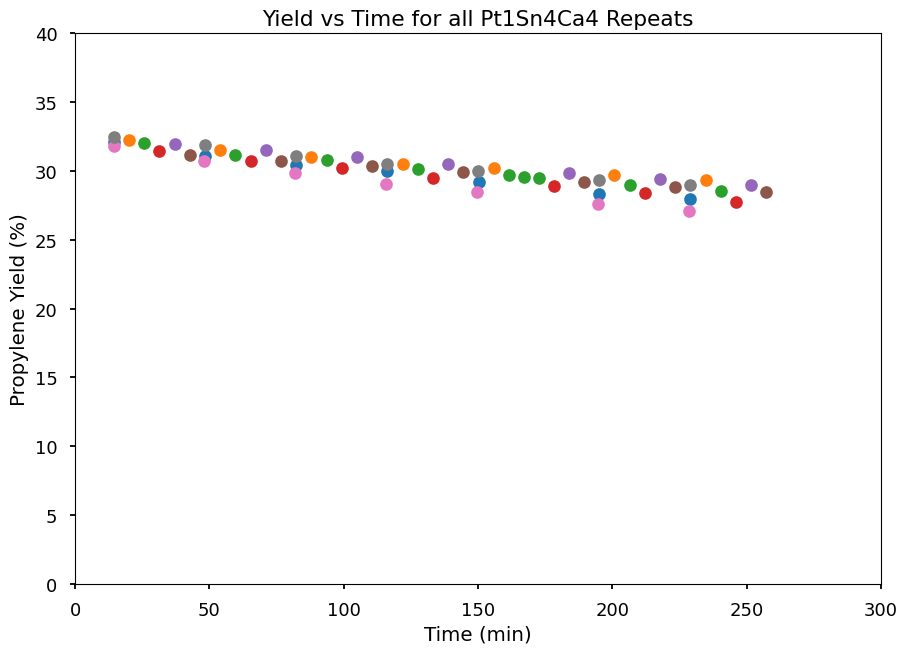

In [76]:
#observe variance in data
for i, cat in enumerate(pt1sn4ca4):
    t = np.asarray(cat["Time Since Start"])
    Y_expt = np.asarray(cat["Conversion"])*np.asarray(cat["Selectivity"])
    t,Y_expt = cb_filter(t,Y_expt,cat)
    plt.plot(t,(Y_expt*100),'o',label=i)
plt.title("Yield vs Time for all Pt1Sn4Ca4 Repeats")
plt.ylim((0,40))
plt.xlim((0,300))
plt.xlabel("Time (min)")
plt.ylabel("Propylene Yield (%)")
#plt.savefig("./figures/pt1sn4ca4-yvst.png",dpi=600)
#plt.show()

## 1b Quality of exponential decay model fit

Text(85, 15, '$Y = Y_0 e^{-k_dt}$')

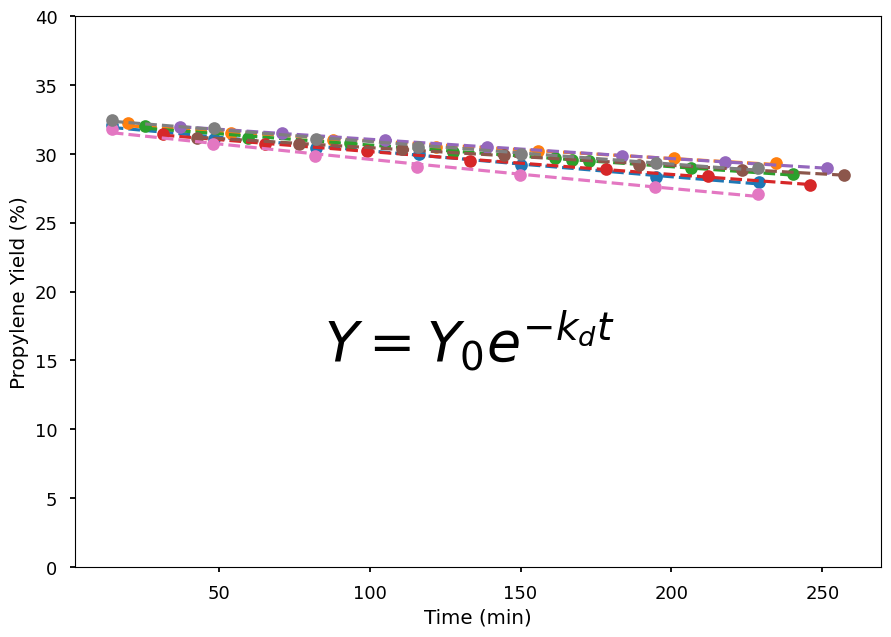

In [135]:
#create linear regression fits
fits = []
i=0
for cat in pt1sn4ca4:
    fit = calc_reactor_metrics(cat) #ignores data with worse than 100 +/- 5% CB
    fits.append(fit)
    t = np.asarray(cat["Time Since Start"])
    Y_expt = np.asarray(cat["Conversion"])*np.asarray(cat["Selectivity"])
    t,Y_expt = cb_filter(t,Y_expt,cat)
    plt.plot(t,100*fit[1]*np.exp(-fit[0]*t),color=cmap(i),linestyle="--")
    plt.plot(t,100*Y_expt,"o")
    i+=1
plt.xlabel("Time (min)")
plt.ylabel("Propylene Yield (%)")
plt.ylim((0,40))
plt.text(85,15,"$Y = Y_0 e^{-k_dt}$",size=40,fontweight='extra bold')
#plt.savefig("./figures/fits-pt1sn4ca4",dpi=600)
   

## 1c Spread in $Y_0$, $k_d$, $Y_{1C}$

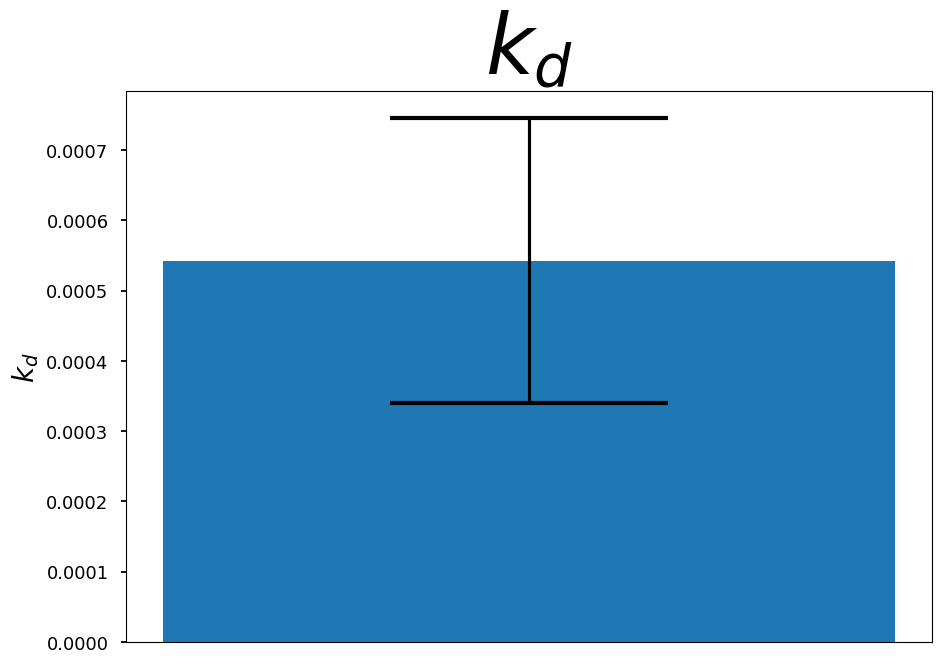

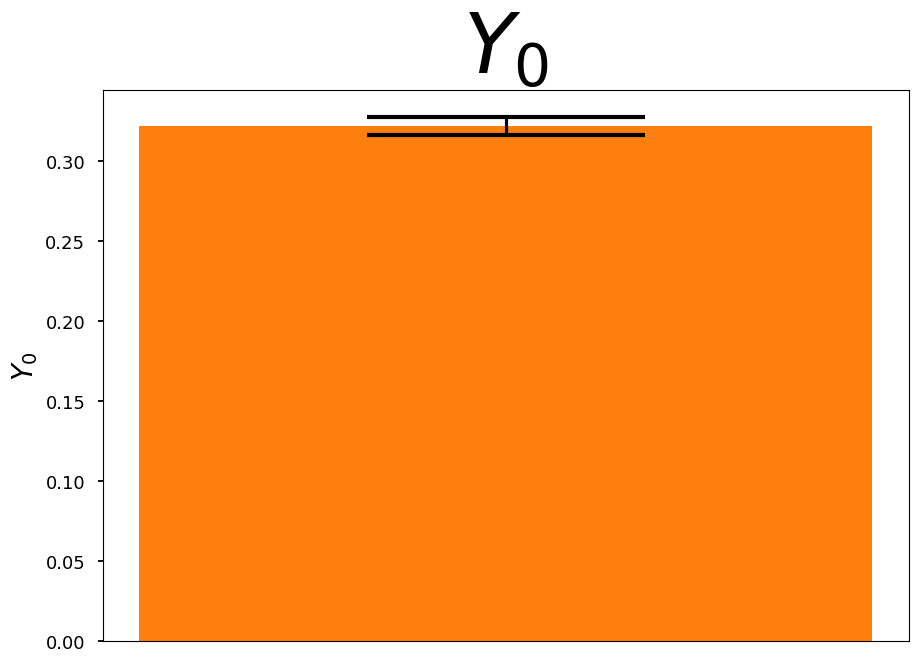

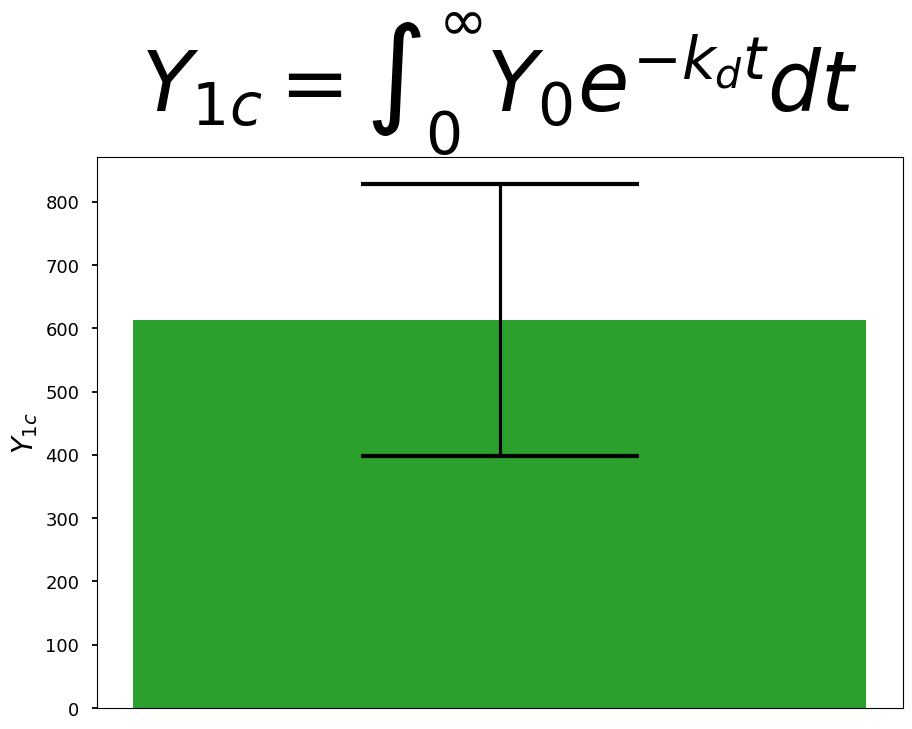

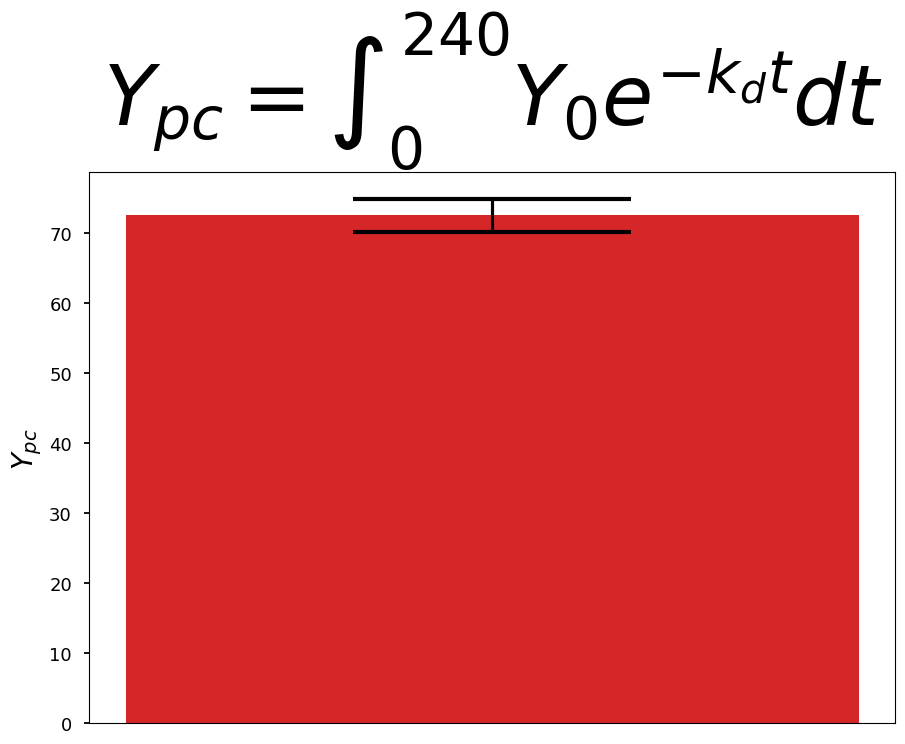

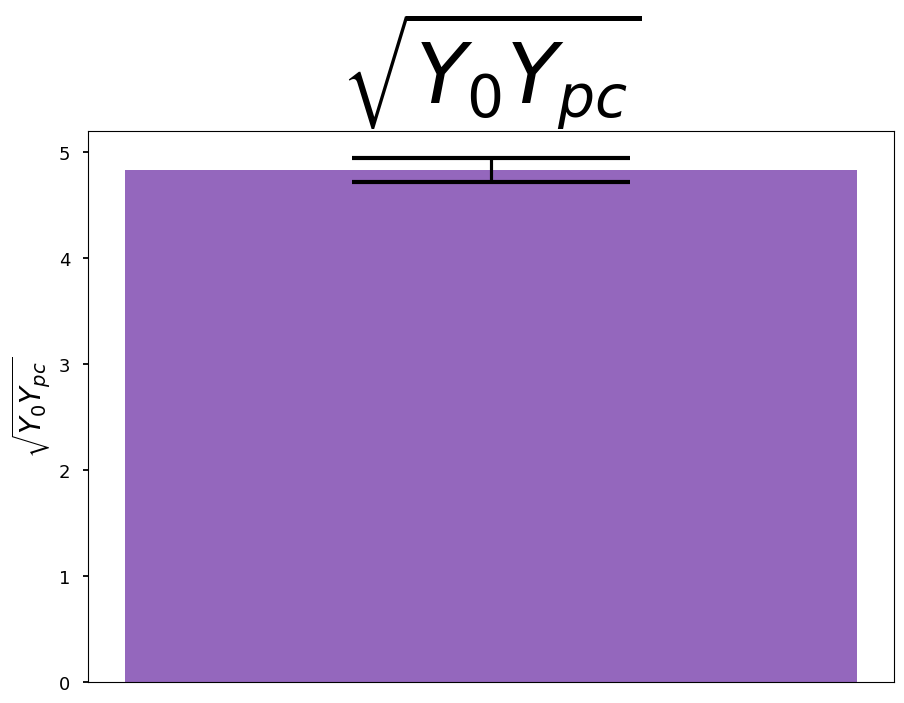

In [134]:
for i, label in enumerate(["kd","Y0","Y1c","Ypc","sqrtY0Ypc"]):
    label_map = ["$k_d$","$Y_0$","$Y_{1c}$","$Y_{pc}$","$\sqrt{Y_0Y_{pc}}$"]
    label_title = ["$k_d$","$Y_0$","$Y_{1c}=\int^{\infty}_{0} Y_0e^{-k_dt}dt$","$Y_{pc}=\int^{240}_{0} Y_0e^{-k_dt}dt$","$\sqrt{Y_0Y_{pc}}$"]
    arr = np.asarray([fit[i] for fit in fits])
    plt.bar([0.5],np.average(arr),yerr=2*np.std(arr),error_kw={"ecolor":'black','capthick':3,'capsize':100},color=cmap(i))
    plt.xticks([], [])
    plt.ylabel(label_map[i],fontsize=20)
    plt.title(label_title[i],fontsize=60)
    #plt.savefig(f'./figures/pt1sn4ca4_{label}.png',dpi=300,bbox_inches="tight")
    plt.show()

*$k_d$ has too much noise. It will cause issues when attempting to predict performance.*

# 2) Partial-Cycle Yield ($Y_{t1-t2}$)

Instead, let's do an integral over part of the time:

$$Y_{t1-t2}=\int^{t_2}_{t1} Y_0e^{-k_dt}dt=\frac{Y_0}{k_d}(e^{-k_dt_1}-e^{-k_dt_2})$$

Let's assess the fit for various t1,t2.

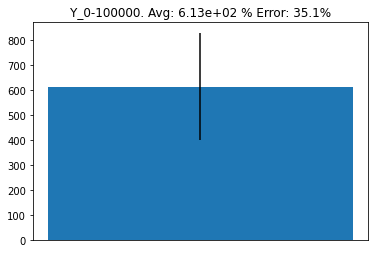

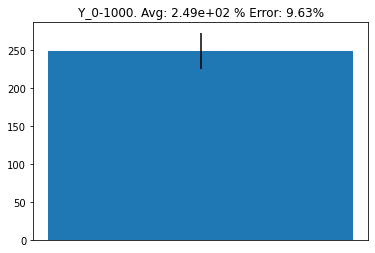

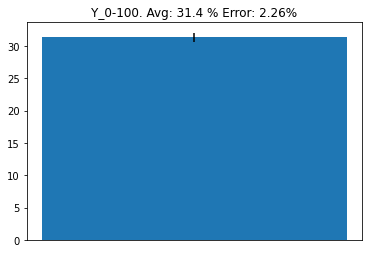

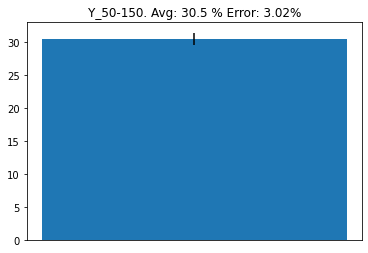

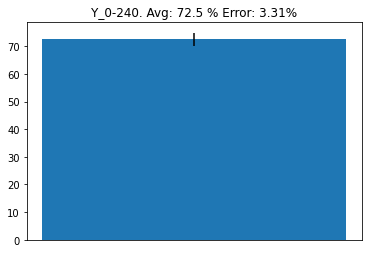

In [47]:
for t1,t2 in [(0,100000),(0,1000),(0,100),(50,150),(0,240)]:
    arr = np.asarray([fit[1]/fit[0]*(np.exp(-fit[0]*t1)-np.exp(-fit[0]*t2)) for fit in fits])
    avg = np.average(arr)
    err = 2*np.std(arr)
    plt.bar([0.5],avg,yerr=err)
    plt.xticks([], [])
    plt.title(f'Y_{t1}-{t2}. Avg: {avg:.3} % Error: {100*err/avg:.3}%')
    #plt.savefig(f'./figures/Y_{t1}-{t2}.png',dpi=600)
    plt.show()

*We will use $t_1=0$, $t_2=240$ because it has much less error while still being a significant quantity of data. It also fits our range of data collection quite closely.*